# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import copy
import sys
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import threading

In [8]:
# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L11
def soft_update(target, source, tau):
    """
    Perform DDPG soft update (move target params toward source based on weight
    factor tau)
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

In [9]:
def transpose_to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float)
    return list(map(make_tensor, zip(*input_list)))

In [10]:
def transpose_list(mylist):
    return list(map(list, zip(*mylist)))

In [11]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=150):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(1, fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=200, fc2_units=150):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size+0, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250       # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-4        # learning rate of the actor 
LR_CRITIC = 1e-3       # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class Agent():
    """Interacts with and learns from the environment."""
    
    # Replay memory
    memory = ReplayBuffer(2, BUFFER_SIZE, BATCH_SIZE, 0)
    
    def __init__(self, state_size, action_size, random_seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        random_seed = 0
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size+action_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size+action_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(self.action_size, random_seed)


    @classmethod
    def add_to_memory(cls, state, action, reward, next_state, done):
        cls.memory.add(state, action, reward, next_state, done)

    @classmethod
    def sample_from_memory(cls):
        return cls.memory.sample()
    
    @classmethod
    def get_memory_length(cls):
        return len(cls.memory)
    
    def step(self, state, action, reward, next_state, done, t):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.add_to_memory(state, action, reward, next_state, done);

        # Learn, if enough samples are available in memory
        if self.get_memory_length() > BATCH_SIZE and t % 2 == 0:
            self.sample_from_memory()
            experiences = self.sample_from_memory()
            self.learn(experiences, GAMMA, t)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, t):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        for _ in range(1):
            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = self.actor_target(next_states)
            Q_targets_next = self.critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
            # Compute critic loss
            Q_expected = self.critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

        for _ in range(1):
            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = self.actor_local(states)
            actor_loss = -self.critic_local(states, actions_pred).mean()
            # Minimize the loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        for _ in range(1):
            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic_local, self.critic_target, TAU, t)
            self.soft_update(self.actor_local, self.actor_target, TAU, t)
        
        
        self.noise.reset()
        
    def soft_update(self, local_model, target_model, tau, t):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250       # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-4        # learning rate of the actor 
LR_CRITIC = 1e-3       # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

Episode 100/4000	Average Score: 0.00200
Episode 200/4000	Average Score: 0.00300
Episode 300/4000	Average Score: 0.00000
Episode 400/4000	Average Score: 0.00000
Episode 500/4000	Average Score: 0.00000
Episode 600/4000	Average Score: 0.00000
Episode 700/4000	Average Score: 0.00000
Episode 800/4000	Average Score: 0.00870
Episode 900/4000	Average Score: 0.17440

Environment solved in 868 episodes!	Average Score: 0.51


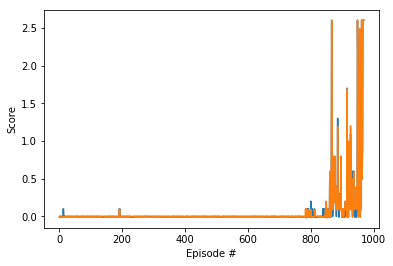

In [13]:
print("""
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250       # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-4        # learning rate of the actor 
LR_CRITIC = 1e-3       # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
""")

def maddpg(agents, n_episodes=4000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=100)
    all_scores = []
    average_scores = []
    for i_episode in range(1, n_episodes+1):
        
        states = env.reset(train_mode=True)[brain_name].vector_observations
        
        [agent.reset() for agent in agents]
        scores = np.zeros(len(agents))
        for t in range(max_t):

            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]
             # Next agent performs action and enviroment advances a time step
            env_info = env.step(actions)[brain_name]
            
            # We record the s', r and if are agent has reached a terminal state
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            [agent.step(states[i], actions[i], rewards[i], 
                        next_states[i], any(dones), t) for i, agent in enumerate(agents)]
            states = next_states
            scores += rewards
            if any(dones):
                break 
        scores_deque.append(np.max(scores))
        all_scores.append(scores)
        average_scores.append(np.mean(scores_deque))

        
        if i_episode % print_every == 0:
            print('\rEpisode {}/{}\tAverage Score: {:.5f}'.format(i_episode, n_episodes, np.mean(scores_deque)))
            sys.stdout.flush()
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agents[0].actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
            torch.save(agents[0].critic_local.state_dict(), 'agent1_checkpoint_critic.pth')
            torch.save(agents[1].actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
            torch.save(agents[1].critic_local.state_dict(), 'agent2_checkpoint_critic.pth')
            break
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(all_scores)+1), all_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
    return all_scores, average_scores

all_scores, average_scores = maddpg(2*[Agent(state_size, action_size)])

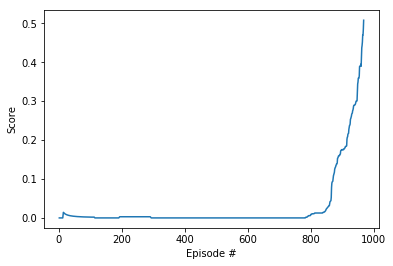

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()